In [29]:
from utils import *

In [30]:
from tqdm import tqdm
import time
from scipy.special import logsumexp
from scipy.stats import multivariate_normal, multivariate_t, random_correlation, truncnorm
import yaml
import os
import imageio
import moviepy.editor as mp

In [45]:
from emukit.core.loop import UserFunctionWrapper
from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization
from emukit.core.loop import UserFunctionResult
from emukit.core import ContinuousParameter, InformationSourceParameter, ParameterSpace

In [3]:
# Load any settings
with open("settings.yaml", mode="r") as file:
    settings = yaml.safe_load(file)

In [4]:
np.random.seed(0)

D = 2
ddof_target = settings['ddof_target']

ddof_proposal = 3

In [5]:
# Target
mean_target = np.zeros(D)
std_devs_target = np.diag(np.sqrt(np.ones(D)*2))
random_corr_mat = random_correlation(eigs=np.ones(D)).rvs(1)
cov_target =  std_devs_target @ random_corr_mat  @ std_devs_target
shape_target = ((ddof_target - 2) / ddof_target) * cov_target

# Proposal
mean_proposal = np.ones(D)*2

std_devs_proposal = np.diag(np.sqrt(np.ones(D)*7))
# For now same correlation as target, just different variances
cov_proposal = std_devs_proposal @ random_corr_mat @ std_devs_proposal

# The Student-t 'shape matrix' is a rescaled covariance
shape_proposal = ((ddof_proposal - 2) / ddof_proposal) * cov_proposal

We implement an escort moment-matching procedure without any temporal mixture and with fixed degrees of freedom. This will be our building bolck for degrees of freedom adaptation.

Consider a family of Student distribution with $\nu$ degrees of freedom.
Set $\alpha = 1 + \frac{2}{\nu + d}$ and initial location and scatter parameters $\mu_0, \Sigma_0$.

For $t=1,\dots,T$:


* Set $\alpha_t = 1 + \frac{2}{\nu_t + d}$.

* Weight the samples from $q(\cdot ; \theta_t)$ (which have already been sampled) using the $\alpha_{t}$-escort of the target: $w_{t}^{(m)} = \frac{\pi(x_{t}^{(m)})^{\alpha_{t}}}{ q(x_{t}^{(m)}; \theta_{t})} $ for $m=1,\dots,M$
* Normalize the weights: $\bar{w}_{t}^{(m)} = \frac{w_{t}^{(m)}}{\sum_{m=1}^{M} w_{t}^{(m)}}$


* Update proposal parameters:
    * $\mu_{t+1} = \sum_{m=1}^{M} \bar{w}_t^{(m)} x_{t}^{(m)}$
    * $\Sigma_{t+1} = \sum_{m=1}^{M} \bar{w}_{t}^{(m)}  (x_{t}^{(m)} - \mu_{t+1})(x_{t}^{(m)} - \mu_{t+1})^\top $
    
  With these weights this corresponds to doing an escort moment-matching update with parameter $\alpha_t$.

* Draw $M$ samples from the novel proposal: $x_{t+1}^{(m)} \sim q(x, \theta_{t+1}), m=1,\dots,M$

* Weight the samples using the target: $w_t^{(m)} = \frac{\pi(x_{t}^{(m)})}{ q(x_{t}^{(m)}; \theta_t)} $ for $m=1,\dots,M$
* Normalize the weights: $\bar{w}_{t+1}^{(m)} = \frac{w_{t+1}^{(m)}}{\sum_{m=1}^{M} w_{t+1}^{(m)}}$
* Compute the $\alpha_t$-ESS: $ESS_{\alpha_t} = \left(\sum_{m=1}^M (\bar{w}_{t+1}^{(m)})^{\alpha_t}\right)^{\frac{1}{1-\alpha_t}}$.
* Use all the values $\{ \nu_{\tau}, ESS_{\alpha_{\tau}} \}_{\tau=1}^t$ to set $\nu_{t+1}$




In [43]:
def escortMM_adaptive_dof(mu_initial,shape_initial, n_iterations, target_pdf, ddof_proposal, M=200):
    
    
    observed_ddof = []
    observed_ess = []
    
    # Iteration 0
    first_proposal = multivariate_t(loc=mu_initial,shape=shape_initial,df=ddof_proposal)
    
    plot_contour_lines(first_proposal, target_pdf, iteration=0)
    
    samples_current = first_proposal.rvs(size=M)
    
    log_numerator = target_pdf.logpdf(samples_current)
    
    log_denominator = first_proposal.logpdf(samples_current) # No temporal mixture in iteration 0

    # assert log_numerator.shape == log_denominator.shape
    current_logweights = log_numerator - log_denominator

    normalized_logweights = current_logweights - logsumexp(current_logweights)

    # Iteration t > 0
    for t in tqdm(range(1,n_iterations)):
        
        alpha = 1 + 2 / (ddof_proposal + D)
        
        ## Update the proposal
        logweights_update = alpha*log_numerator - log_denominator
        normalized_logweights_update = logweights_update - logsumexp(logweights_update)
        
        mu_current = np.zeros(D)
        for m in range(M):
            mu_current += np.exp(normalized_logweights_update[m]) * samples_current[m, :]
        
        shape_current = np.zeros((D, D))
        for m in range(M):
            shape_current += np.exp(normalized_logweights_update[m]) * (samples_current[m, :].reshape(-1, 1) @ samples_current[m, :].reshape(1, -1))
        
        current_proposal = multivariate_t(loc=mu_current, shape=shape_current, df=ddof_proposal)
         
        
        # Plot current proposal vs target
        plot_contour_lines(current_proposal, target_pdf, iteration=t)
        
        ## Sampling from the new proposal
        samples_current = current_proposal.rvs(size=M)
    
        log_numerator = target_pdf.logpdf(samples_current)
    
        log_denominator = current_proposal.logpdf(samples_current)
        
        

        ## Evaluate the next ddof
        
        logweights_ess = log_numerator - log_denominator
        normalized_logweights_ess = logweights_ess - logsumexp(logweights_ess)

        ESS_alpha = sum(np.exp(alpha*normalized_logweights_ess))**(1 / (1-alpha))
        
        observed_ddof.append(ddof_proposal)
        observed_ess.append(ESS_alpha)
        
        if t <= 3:
            #we accumulate a few observations with randomly chosen ddof before starting the Bayesian optimization
            rv = truncnorm(-ddof_proposal, 100)
            ddof_proposal = rv.rvs() + ddof_proposal
            
        else:
            #we have enough data points to start optimizing in a Bayesian fashion
            space = ParameterSpace([ContinuousParameter("x", 0, 20)])
            bo = GPBayesianOptimization(variables_list=space.parameters, X=observed_ddof, Y=observed_ess)
            results = None
            x_new = bo.get_next_points(results)
            
            ddof_proposal = x_new
            
    return observed_ddof
        
        
        
        
        
        

 10%|████▌                                       | 3/29 [00:00<00:07,  3.35it/s]


AttributeError: 'list' object has no attribute 'ndim'

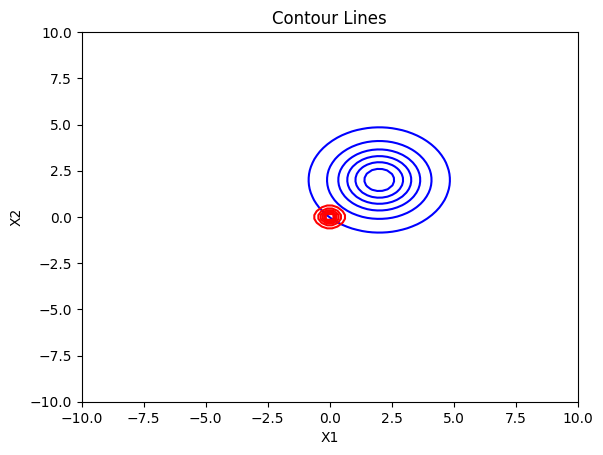

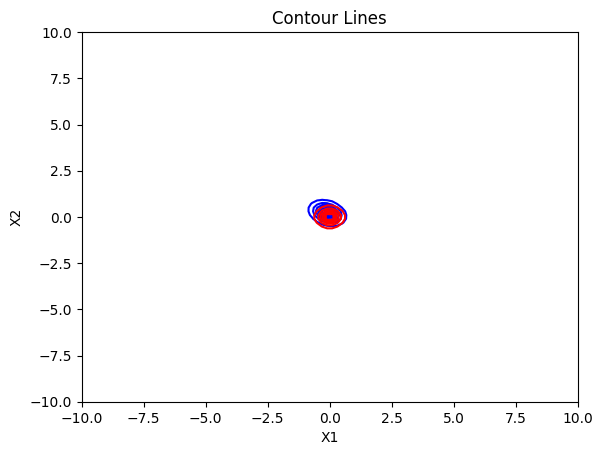

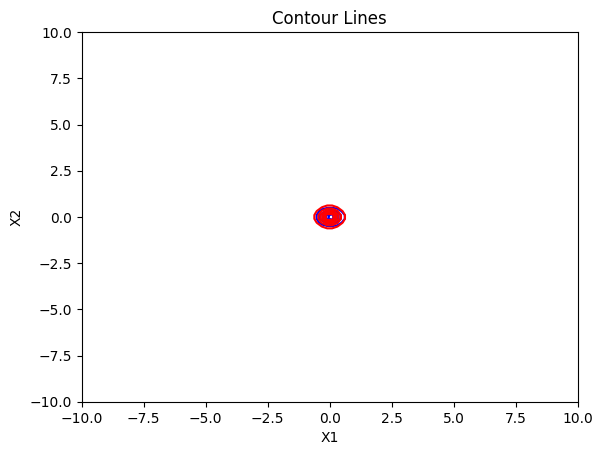

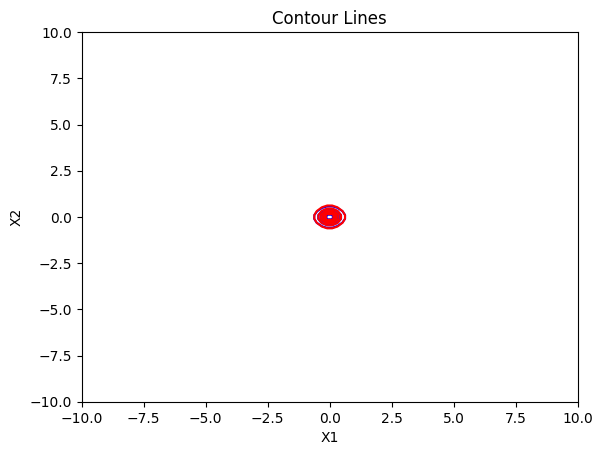

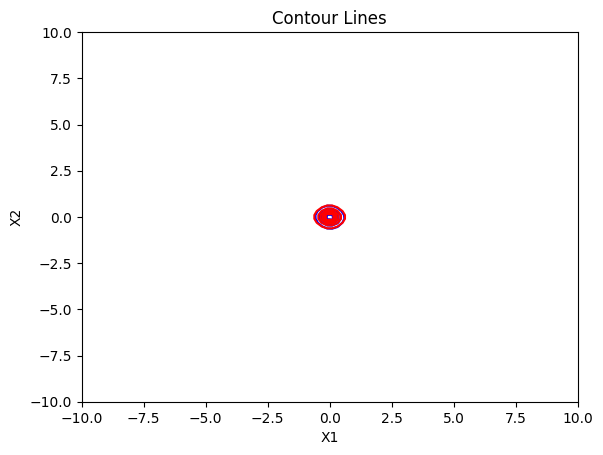

In [46]:
escortMM_adaptive_dof(mu_initial=mean_proposal,shape_initial=shape_proposal, n_iterations=30, target_pdf=multivariate_t(loc=mean_target,shape=shape_target,df=ddof_target), ddof_proposal=ddof_proposal)